# 2020 so far: are people more depressed than usual?
This has not been an easy year: Australian fires, possibility of a new world war happening, the coronavirus pandemic, world economy shifting and people being forced to stay at home due to lockdown. With so many unexpected challenges, it would be intuitive to assume that our mental health has suffered significantly, probably more so than in previous years.<br><br>In order to confirm this suspicion, I will be analysing data from Reddit – a social news website. Even though the site is in no way representative of the world population (as more than half of its user base is American), it could still be insightful to understand how its users have been impacted.

### Here is a quick overview of how Reddit works:
- There are multiple communities called subreddits; each subreddit has a unique name and it is centered around a certain topic in life
- People can subscribe to subreddits and submit their own posts (text/pictures/videos), and also comment on each other's submissions
- Reddit is usually anonymous, with users having nicknames that could not be linked to their real-world persona.

In the current project, I am going to focus on three of the most popular subreddits centered around depression: r/depressed, r/depression_help and r/depression. I am going to explore how engaged the community was with those specific subreddits during the first half of 2020, and see if similar levels of engagement were evident in 2018 and 2019. I will be using the complete data available for those periods (every single submission, not just a subset). I will also be looking at each subreddit separately, focusing mostly on three metrics: number of submissions, comments and subscribers. If people have been more depressed recently, we would expect a more rapid increase of those compred to previous years.

### Here are the main steps that need to be followed:
1. Making an API request to fetch the data for the relevant periods.<br><i>Libraries used: requests, time and json.</i>
2. Creating a dataframe containing all the submissions and other metrics.<br><i>Libraries used: pandas and NumPy.</i>
3. Aggregating the data into months and years.
4. Visualising the data.<br><i>Libraries used: Matplotlib, matplotlib-venn.</i>
5. Interpreting the numbers and graphs.

The full, annotated code is available below, and some of the more technical details are also discussed. Readers not interested in those may want to jump straight to the interpretation of the results and the graphs.

In [1]:
# Importing all necessary libraries.
import requests
import time
import json
from json.decoder import JSONDecodeError
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn import venn3_unweighted
import warnings

# Ignoring future warnings that are irrelevant in our case.
warnings.filterwarnings('ignore')

# Displaying all graphs in the notebook.
%matplotlib inline

In [2]:
# Defining functions that will fetch any posts in a given subreddit between January and June for 3 years in a row (2018–2020). We will use the pushshift API because it allows us to access posts that are much older and also start before/after a certain date.
def api_request(subreddit, date_before):
    # Trying 10 times in a row in case the server throws up an error.
    for number_try in range(10):
        try:
            posts = requests.get('https://api.pushshift.io/reddit/search/submission',
                                 headers={'User-Agent': 'DepressionCrawl'},
                                 params={'subreddit': subreddit,
                                         'before': date_before,
                                         'size':100})
            date_last_post = posts.json()['data'][-1]['created_utc']
        except JSONDecodeError:
            if number_try == 9:
                print('Too many errors.')
            else:
                print('Bad gateway error. Retrying…')
        else:
            return date_last_post, posts
        break

def fetch_posts(subreddit):    
    all_posts = []
    i = 0
    # Defining dates according to Unix time.
    jan2018, jan2019, jan2020, = 1514764800, 1546300800, 1577836800
    jul2018, jul2019, jul2020 = 1530403200, 1561939200, 1593561600
    while True:
        # We are starting with the newest post (Jun 2020 and before), and then we are jumping to previous years each time i gets updated.
        if i == 0:
            date_last_post, posts = api_request(subreddit, jul2020)
            i = 10
        elif jan2020 <= date_last_post:
            date_last_post, posts = api_request(subreddit, date_last_post+1)
            if jan2020 >= date_last_post:
                i = 1
        elif i == 1:
            date_last_post, posts = api_request(subreddit, jul2019)
            i = 10
        elif jan2019 <= date_last_post:
            date_last_post, posts = api_request(subreddit, date_last_post+1)
            if jan2019 >= date_last_post:
                i = 2
        elif i == 2:
            date_last_post, posts = api_request(subreddit, jul2018)
            i = 10
        elif jan2018 <= date_last_post:
            date_last_post, posts = api_request(subreddit, date_last_post+1)
        
        # Appending every fetched post to a list.
        for p in range(len(posts.json()['data'])):
            all_posts.append(posts.json()['data'][p])   
        
        # Breaking the loop after reaching dates older than 2018.
        if jan2018 >= date_last_post:
            break
            # Spacing out the requests.
        time.sleep(3)
    
    # Creating a .txt file with the posts.
    with open('r_' + subreddit + '.txt', 'a') as f:
        json.dump(all_posts, f)

In [3]:
# Reading the posts of each subreddit into a dictionary. We will be working with r/depressed, r/depression_help and r/depression.
depression_subreddits = {}

# fetch_posts('depressed')
with open('r_depressed.txt', 'r') as f:
    depression_subreddits['r/depressed'] = json.loads(f.read())

# fetch_posts('depression_help')
with open('r_depression_help.txt', 'r') as f:
    depression_subreddits['r/depression_help'] = json.loads(f.read())
    
# fetch_posts('depression')
with open('r_depression.txt', 'r') as f:
    depression_subreddits['r/depression'] = json.loads(f.read())

In [4]:
# Creating a dataframe of all the posts of each subreddit and only chosing relevant columns: unique ID of the post, date the post was created, author of the post, title, number of comments and number of subscribers at the time the post was created.
for subreddit, posts in depression_subreddits.items():
    subreddit_df = pd.DataFrame(posts, columns=['id', 'created_utc',
                                                           'author', 'title', 'num_comments', 'subreddit_subscribers'])
    subreddit_df.columns = ['ID', 'Date created', 'Author', 'Title', 'Comments', 'Subscribers']

    # Dropping duplicates. The first line drops rows that have identical values for all columns, and the second line drops only rows that have identical titles and authors (i.e. the same submitted the same post two or more times).
    subreddit_df.drop_duplicates(inplace=True)
    subreddit_df.drop_duplicates(subset=['Title', 'Author'], inplace=True)

    # The way fetching data works, it is very possible that we also have some entries that are outside the defined period (Jan–Jun 2018, 2019, 2020). We are going to remove them after converting the dates from unix time to pandas' own timestamps.
    subreddit_df['Date created'] = pd.to_datetime(subreddit_df['Date created'], unit='s')
    jan2018, jan2019, jan2020 = pd.Timestamp(2018, 1, 1), pd.Timestamp(2019, 1, 1), pd.Timestamp(2020, 1, 1)
    jul2018, jul2019, jul2020 = pd.Timestamp(2018, 7, 1), pd.Timestamp(2019, 7, 1), pd.Timestamp(2020, 7, 1)
    exclude_dates_1 = (subreddit_df['Date created'] < jul2020) & (subreddit_df['Date created'] > jan2018)
    subreddit_df = subreddit_df[exclude_dates_1]
    exclude_dates_2 = (subreddit_df['Date created'] >= jan2020) | (subreddit_df['Date created'] < jul2019)
    subreddit_df = subreddit_df[exclude_dates_2]
    exclude_dates_3 = (subreddit_df['Date created'] >= jan2019) | (subreddit_df['Date created'] < jul2018)
    subreddit_df = subreddit_df[exclude_dates_3]

    # Sorting the entries with the oldest one at the top and resetting the index.
    subreddit_df.sort_values('Date created', inplace=True)
    subreddit_df.reset_index(drop=True, inplace=True)
    
    # Assigning each dataset back to the original dictionary.
    depression_subreddits[subreddit] = subreddit_df

# Taking a look at the first five and last five rows of the dataset.
subreddit_df.head().append(subreddit_df.tail())

,ID,Date created,Author,Title,Comments,Subscribers
0,7nbxyt,2018-01-01 00:00:22,[deleted],Happy new year,1,NaN
1,7nby6m,2018-01-01 00:01:40,Pro_nO0b,Happy new year to all of you,2,NaN
2,7nby9n,2018-01-01 00:02:09,meaninglessworld1,"The most perfect soulmate - out of reach, ""gla...",0,NaN
3,7nbyg0,2018-01-01 00:03:14,vegavalentine,Thank you,2,NaN
4,7nbyia,2018-01-01 00:03:35,throw_away_posts,Two years,0,NaN
327688,hiz9tr,2020-06-30 23:54:35,samsabitfukedup,I hate myself,1,652115.0
327689,hiz9y6,2020-06-30 23:54:50,christian_throwway,I think I might be having mild olfactory and a...,3,652115.0
327690,hizag4,2020-06-30 23:55:40,throw_990_away,I’ve been working hard,2,652115.0
327691,hizba9,2020-06-30 23:57:10,euanmac369,Watching the girl you like end up with someone...,2,652115.0
327692,hizcmd,2020-06-30 23:59:33,Zcunts,I now see happiness as a temporary distraction...,0,652117.0


Just to get an understanding of the data: those are the first and last few rows of r/depression, but the structure for the other two subreddits is identical.

Some notes:
- "[deleted]" usually means that the author themselves deleted their profile on Reddit at some point after they submitted the post
- There are missing values (NaN) for the number of subscribers at the time some of the posts were made, but we are going to deal with those later.

In [5]:
# Exctracting the number of rows in each dataset and summing it up to obtain the total number of entries we will be working with.
total_data_entries = [subreddit_df.shape[0] for subreddit_df in depression_subreddits.values()]
print('Total entries: {:,.0f}\n\nr/depressed: {:,.0f}\nr/depression_help: {:,.0f}\nr/depression: {:,.0f}'.format(sum(total_data_entries), total_data_entries[0], total_data_entries[1], total_data_entries[2]))

Total entries: 351,331

r/depressed: 6,305
r/depression_help: 17,333
r/depression: 327,693


## The three subreddits
We can see that the overwhelming majority of entries come from r/depression. This is also the biggest subreddit about depression (in terms of submissions), with r/depressed being the smallest of the three.

As of June 2020, the subreddits had the following subtitles and descriptions:<br><br>
<b>r/depressed</b><br>
Subtitle: "anyone there?"<br>
Description: "A community for people who are depressed or suffer from depression. If you're depressed, feeling hopeless, or if someone you know suffers from depression, feel free to share your feelings, your situation, and what's on your mind."<br><br>
<b>r/depression_help</b><br>
Subtitle: "Depression Help"<br>
Description: "Life can be tough; we all experience difficult obstacles at some point in our lives and to overcome them, we need support and inspiration. r/depression_help provides a platform for you to get the support, advice, inspiration and motivation you need to make the best of your life with the mental illness - depression."<br><br>
<b>r/depression</b><br>
Subtitle: "/r/depression, because nobody should be alone in a dark place"<br>
Description: "Peer support for anyone struggling with depression, the mental illness."<br><br>
We can infer that all three subreddits are indeed similar in scope.<br><br>
As a next step, we are going to aggregate the posts into months and years.

In [6]:
# Aggregating the dates into months. We first crete intervals (bins).
for subreddit, subreddit_df in depression_subreddits.items():
    bins = pd.IntervalIndex([pd.Interval(pd.Timestamp(2018, 1, 1), pd.Timestamp(2018, 2, 1), 'right'),
                            pd.Interval(pd.Timestamp(2018, 2, 1), pd.Timestamp(2018, 3, 1), 'right'),
                            pd.Interval(pd.Timestamp(2018, 3, 1), pd.Timestamp(2018, 4, 1), 'right'),
                            pd.Interval(pd.Timestamp(2018, 4, 1), pd.Timestamp(2018, 5, 1), 'right'),
                            pd.Interval(pd.Timestamp(2018, 5, 1), pd.Timestamp(2018, 6, 1), 'right'),
                            pd.Interval(pd.Timestamp(2018, 6, 1), pd.Timestamp(2018, 7, 1), 'right'),
                            pd.Interval(pd.Timestamp(2019, 1, 1), pd.Timestamp(2019, 2, 1), 'right'),
                            pd.Interval(pd.Timestamp(2019, 2, 1), pd.Timestamp(2019, 3, 1), 'right'),
                            pd.Interval(pd.Timestamp(2019, 3, 1), pd.Timestamp(2019, 4, 1), 'right'),
                            pd.Interval(pd.Timestamp(2019, 4, 1), pd.Timestamp(2019, 5, 1), 'right'),
                            pd.Interval(pd.Timestamp(2019, 5, 1), pd.Timestamp(2019, 6, 1), 'right'),
                            pd.Interval(pd.Timestamp(2019, 6, 1), pd.Timestamp(2019, 7, 1), 'right'),
                            pd.Interval(pd.Timestamp(2020, 1, 1), pd.Timestamp(2020, 2, 1), 'right'),
                            pd.Interval(pd.Timestamp(2020, 2, 1), pd.Timestamp(2020, 3, 1), 'right'),
                            pd.Interval(pd.Timestamp(2020, 3, 1), pd.Timestamp(2020, 4, 1), 'right'),
                            pd.Interval(pd.Timestamp(2020, 4, 1), pd.Timestamp(2020, 5, 1), 'right'),
                            pd.Interval(pd.Timestamp(2020, 5, 1), pd.Timestamp(2020, 6, 1), 'right'),
                            pd.Interval(pd.Timestamp(2020, 6, 1), pd.Timestamp(2020, 7, 1), 'right')])
    subreddit_df['Month'] = pd.cut(subreddit_df['Date created'], bins=bins)
    labels = ['Jan 18', 'Feb 18', 'Mar 18', 'Apr 18', 'May 18', 'Jun 18', 'Jan 19', 'Feb 19', 'Mar 19', 'Apr 19', 'May 19', 'Jun 19', 'Jan 20', 'Feb 20',
              'Mar 20', 'Apr 20', 'May 20', 'Jun 20']
    subreddit_df['Month'].cat.rename_categories(labels, inplace=True)
    
    # Aggregating the dates, this time into years, and reordering the columns.
    subreddit_df['Year'] = np.select([subreddit_df['Date created'] < pd.Timestamp(2019, 1, 1),
                                     subreddit_df['Date created'] < pd.Timestamp(2020, 1, 1)],
                                    [2018, 2019], default=2020)
    subreddit_df = subreddit_df[['ID', 'Date created', 'Month', 'Year', 'Author', 'Title', 'Comments', 'Subscribers']]
    
    # Assigning each dataset back to the original dictionary.
    depression_subreddits[subreddit] = subreddit_df
    
# Taking a look at the first five and last five rows of the dataset.
subreddit_df.head().append(subreddit_df.tail())

,ID,Date created,Month,Year,Author,Title,Comments,Subscribers
0,7nbxyt,2018-01-01 00:00:22,Jan 18,2018,[deleted],Happy new year,1,NaN
1,7nby6m,2018-01-01 00:01:40,Jan 18,2018,Pro_nO0b,Happy new year to all of you,2,NaN
2,7nby9n,2018-01-01 00:02:09,Jan 18,2018,meaninglessworld1,"The most perfect soulmate - out of reach, ""gla...",0,NaN
3,7nbyg0,2018-01-01 00:03:14,Jan 18,2018,vegavalentine,Thank you,2,NaN
4,7nbyia,2018-01-01 00:03:35,Jan 18,2018,throw_away_posts,Two years,0,NaN
327688,hiz9tr,2020-06-30 23:54:35,Jun 20,2020,samsabitfukedup,I hate myself,1,652115.0
327689,hiz9y6,2020-06-30 23:54:50,Jun 20,2020,christian_throwway,I think I might be having mild olfactory and a...,3,652115.0
327690,hizag4,2020-06-30 23:55:40,Jun 20,2020,throw_990_away,I’ve been working hard,2,652115.0
327691,hizba9,2020-06-30 23:57:10,Jun 20,2020,euanmac369,Watching the girl you like end up with someone...,2,652115.0
327692,hizcmd,2020-06-30 23:59:33,Jun 20,2020,Zcunts,I now see happiness as a temporary distraction...,0,652117.0


We now have columns for the month and the year of each post, so now it is a good idea to aggregate the data according to that. Next, I will be creating a multi-index that has the year as a first level and the month as a second level.

In [7]:
# Summarising the data into months for each subreddit. The total ID count will give us the number of submissions, then we have the total comments and the total subcribers at the end of the month (taken from the last submission).
depression_subreddits_monthly = {}
for subreddit, subreddit_df in depression_subreddits.items():

    # Grouping by year and month and creating a multi-index.
    subreddit_df_monthly = subreddit_df.groupby(['Year', 'Month']).agg({'ID':'count', 'Comments':'sum', 'Subscribers':'last'})
    subreddit_df_monthly.columns = ['Submissions', 'Comments', 'Subscribers']
    years_months = [[2018, 2018, 2018, 2018, 2018, 2018, 2019, 2019, 2019, 2019, 2019, 2019, 2020, 2020, 2020, 2020, 2020, 2020],
                          ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']]
    years_months_tuple = list(zip(*years_months))
    index_years_months = pd.MultiIndex.from_tuples(years_months_tuple, names=['Year', 'Month'])
    subreddit_df_monthly.index = index_years_months
    
    # Assigning each dataset back to a new dictionary.
    depression_subreddits_monthly[subreddit] = subreddit_df_monthly
    
    # Printing the rows for each dataset that have a missing value.
    print('{}:\n{}\n'.format(subreddit, subreddit_df_monthly[subreddit_df_monthly.isnull().any(axis=1)]))
    
# Taking a look at the complete dataset.
subreddit_df_monthly

r/depressed:
            Submissions  Comments  Subscribers
Year Month                                    
2018 Jan            116       426          NaN
     Feb            101       307          NaN

r/depression_help:
            Submissions  Comments  Subscribers
Year Month                                    
2018 Jan            625      1449          NaN
     Feb            469      1126          NaN

r/depression:
            Submissions  Comments  Subscribers
Year Month                                    
2018 Jan          15470     61682          NaN
     Feb          14570     61714          NaN



Submissions  Comments  Subscribers
Year Month                                    
2018 Jan          15470     61682          NaN
     Feb          14570     61714          NaN
     Mar          15919     55247     341004.0
     Apr          15608     57061     350047.0
     May          14496     52952     357393.0
     Jun          14969     55543     365635.0
2019 Jan          17072     62380     435565.0
     Feb          16658     57875     447508.0
     Mar          19316     67381     466110.0
     Apr          19021     68073     478776.0
     May          19701     66694     490716.0
     Jun          19919     69381     502648.0
2020 Jan          23107     84403     596688.0
     Feb          21645     74312     608811.0
     Mar          20033     63252     619132.0
     Apr          18989     58343     629174.0
     May          20697     60909     641090.0
     Jun          20503     63841     652117.0

## The complete datasets
The datasets are a lot neater that way, and we can already notice some trends just by looking at the table. It is now time that we dealt with the missing values that we noticed earlier. Looks like they are the same for all three subreddits: subscribers are missing for January and February 2018. In the next step, we are going to impute the missing values.

In [8]:
for subreddit, subreddit_df_monthly in depression_subreddits_monthly.items():
    # Calculating the new subscribers per month, which is esentially the difference in subscribers between two consecutive months. 
    subreddit_df_monthly['New subscribers'] = subreddit_df_monthly['Subscribers'].diff()
    
    # For some reason, subscribers data for Jan and Feb 2018 is missing. We are going to impute the missing values for new subscribers with the average number of new subscribers for Apr–June of that year. 
    subreddit_df_monthly['New subscribers'].fillna(subreddit_df_monthly['New subscribers'].iloc[:6].mean(), inplace=True)
    # We're now using the newly imputed new subscribers calculate the total subscribers for Jan and Feb 2018.
    subreddit_df_monthly['Subscribers'].iloc[1] = subreddit_df_monthly['Subscribers'].iloc[2] - subreddit_df_monthly['New subscribers'].iloc[1]
    subreddit_df_monthly['Subscribers'].iloc[0] = subreddit_df_monthly['Subscribers'].iloc[1] - subreddit_df_monthly['New subscribers'].iloc[0]
    
    # We will also need to replace the number of new subscribers for Jan 2019 and 2020 because the previous month in the dataset is June 2018/2019, not December! Because we don't have the data for December, we will simply calculate the difference between the end and he beginning of Jan (i.e. last minus first post for Jan).
    first_month_2019 = depression_subreddits[subreddit]['Month'] == 'Jan 19'
    subreddit_df_monthly['New subscribers'].iloc[6] = (depression_subreddits[subreddit].loc[first_month_2019, 'Subscribers'].iloc[-1] - depression_subreddits[subreddit].loc[first_month_2019, 'Subscribers'].iloc[0])
    first_month_2020 = depression_subreddits[subreddit]['Month'] == 'Jan 20'
    subreddit_df_monthly['New subscribers'].iloc[12] = (depression_subreddits[subreddit].loc[first_month_2020, 'Subscribers'].iloc[-1] - depression_subreddits[subreddit].loc[first_month_2020, 'Subscribers'].iloc[0])

    # Converting the columns from floats to integers. This is not mandatory, but it is more convenient that way because they are not actually floats (they were originally because of their missing values).
    subreddit_df_monthly['Subscribers'] = subreddit_df_monthly['Subscribers'].astype('int')
    subreddit_df_monthly['New subscribers'] = subreddit_df_monthly['New subscribers'].astype('int')
    
    depression_subreddits_monthly[subreddit] = subreddit_df_monthly

In [9]:
# Summarising the data into years for each subreddit.
depression_subreddits_yearly = {}
for subreddit, subreddit_df_monthly in depression_subreddits_monthly.items():
    subreddit_df_yearly = subreddit_df_monthly.groupby(level=0).agg({'Submissions':'sum',
                                                                      'Comments': 'sum',
                                                                      'Subscribers':'last',
                                                                      'New subscribers':'sum'})
    
    # Assigning each dataset back to a new dictionary.
    depression_subreddits_yearly[subreddit] = subreddit_df_yearly
    
subreddit_df_yearly

,Submissions,Comments,Subscribers,New subscribers
Year,,,,
2018,91032,344199,365635,49261
2019,111687,391784,502648,80401
2020,124974,405060,652117,69105


And this is the data for r/depression aggregated by years only.

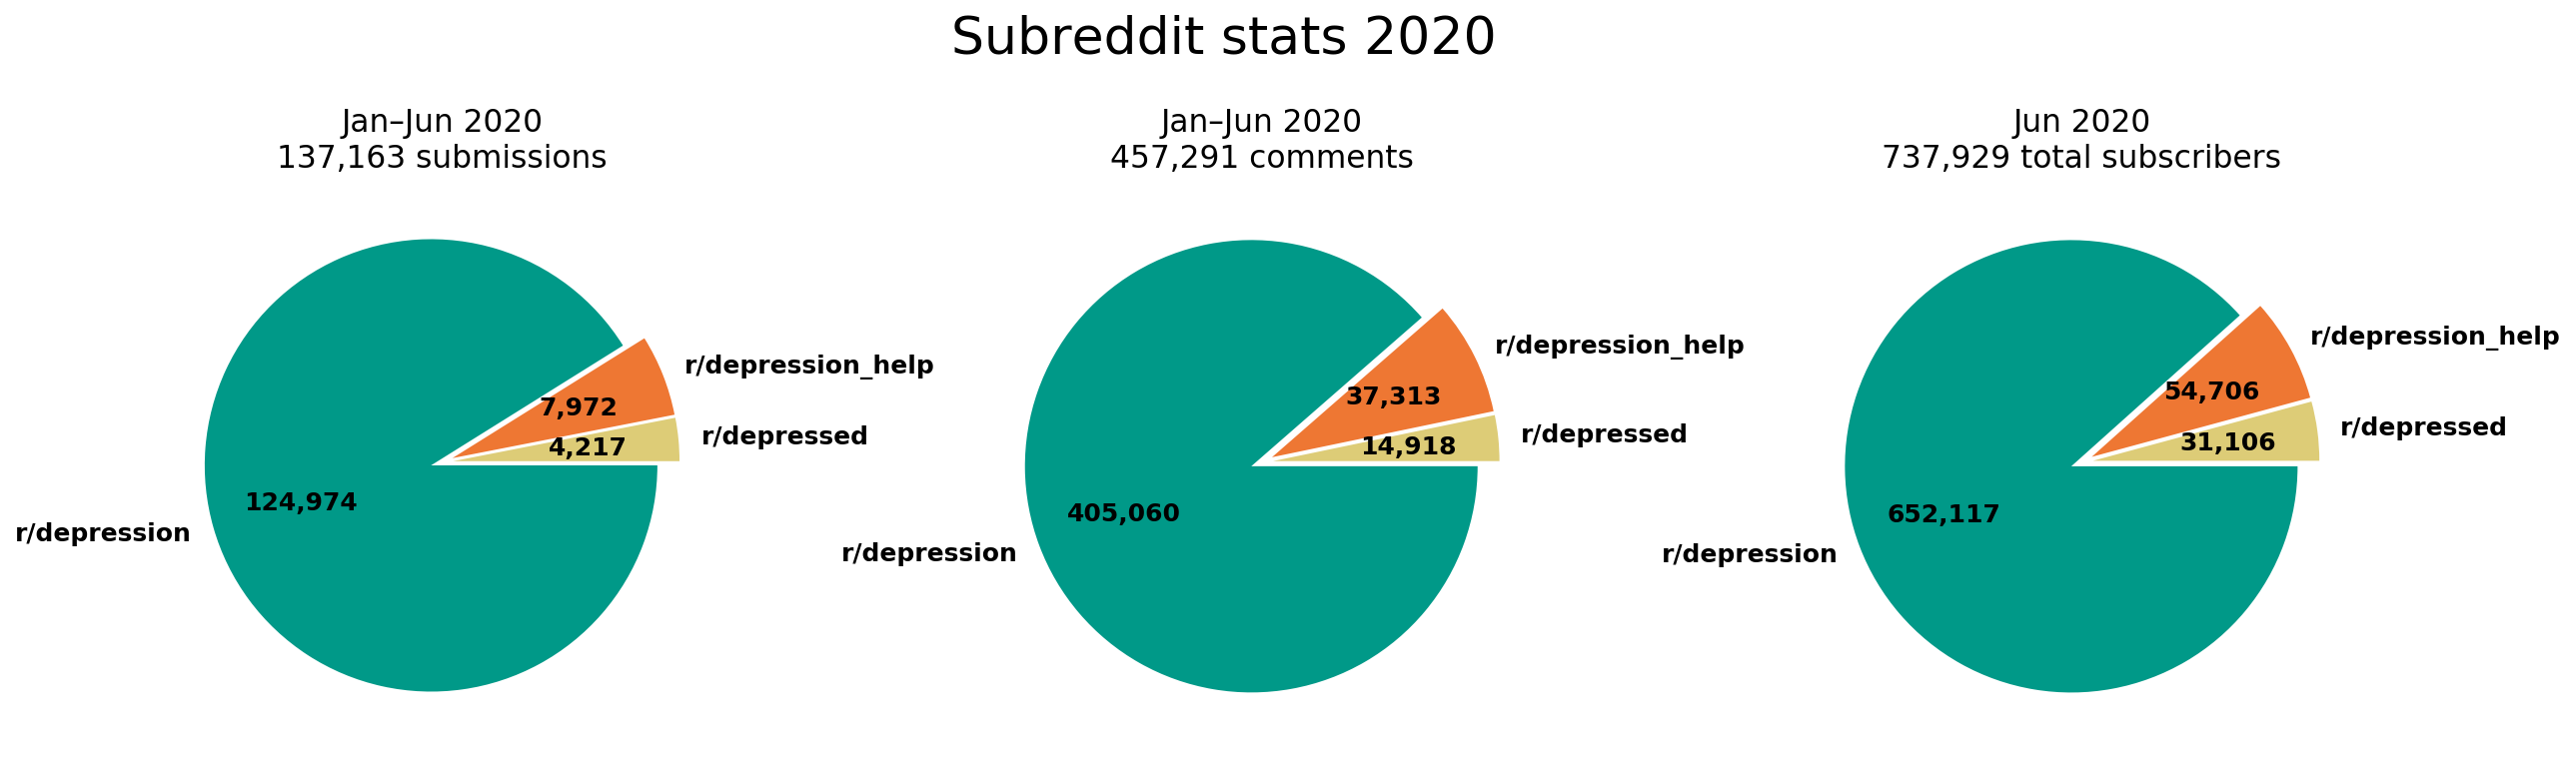

Submissions per subscriber: 0.19
Comments per subscriber: 0.62


In [10]:
# Creating a dictionary that contains the number of submissions, comments and subscribers of each subreddit for 2020.
depression_subreddits_stats2020 = {}
depression_subreddits_stats2020['depression_subreddits_submissions'] = [depression_subreddits_yearly['r/depressed'].iloc[2,0],
                                          depression_subreddits_yearly['r/depression_help'].iloc[2,0],
                                          depression_subreddits_yearly['r/depression'].iloc[2,0]]
depression_subreddits_stats2020['depression_subreddits_comments'] = [depression_subreddits_yearly['r/depressed'].iloc[2,1],
                                          depression_subreddits_yearly['r/depression_help'].iloc[2,1],
                                          depression_subreddits_yearly['r/depression'].iloc[2,1]]
depression_subreddits_stats2020['depression_subreddits_total_subscribers'] = [depression_subreddits_yearly['r/depressed'].iloc[2,2],
                                          depression_subreddits_yearly['r/depression_help'].iloc[2,2],
                                          depression_subreddits_yearly['r/depression'].iloc[2,2]]

# Displaying the information via pie charts. We're fist going to define a figure (with size and resolution) and then use a for loop to create three axes/charts next to each other, for submissions, comments and subscribers respectively.
fig_pie = plt.figure(figsize=(20, 5), dpi=150)
for i, stat in enumerate(depression_subreddits_stats2020.keys()):
    ax = fig_pie.add_subplot(1, 3, i+1)
    # Generating the actual pie chart and adding the stats of each subreddit inside.
    texts = ax.pie(depression_subreddits_stats2020[stat], labels=depression_subreddits_yearly.keys(),
           autopct=lambda p:'{:,.0f}'.format(p * sum(depression_subreddits_stats2020[stat]) / 100), colors=['#DDCC77', '#EE7733', '#009988'],
           explode=(0.05, 0.05, 0.05), textprops={'fontweight': 'bold', 'fontsize':12})
    
    # Setting a different title for each chart. It also includes the total submissions/comments/subscribers across all subreddits.
    if i == 0:
        submissions_sum = sum(depression_subreddits_stats2020[stat])
        ax.set_title('Jan–Jun 2020\n{:,.0f} submissions'.format(submissions_sum),fontsize=15, x=0.5)
    elif i == 1:
        comments_sum = sum(depression_subreddits_stats2020[stat])
        ax.set_title('Jan–Jun 2020\n{:,.0f} comments'.format(comments_sum),fontsize=15, x=0.5)
    else:
        subscribers_sum = sum(depression_subreddits_stats2020[stat])
        ax.set_title('Jun 2020\n{:,.0f} total subscribers'.format(subscribers_sum),fontsize=15, x=0.5)

# Saving the figure as a .png file and adding a title.
fig_pie.savefig('depression_subreddits_pie.png', format='png', bbox_inches = "tight")
fig_pie.suptitle('Subreddit stats 2020', fontsize=25, y=1.1, x=0.5)    
plt.show()
print('Submissions per subscriber: {:.2f}\nComments per subscriber: {:.2f}'.format(submissions_sum/subscribers_sum, comments_sum/subscribers_sum))

The pie charts give us an overview of the number of submissions and comments for the first half of 2020, as well as the total subscribers at the end of that period. Again, r/depression is clearly the biggest subreddit of the three.

Also, there are about 0.19 submissions per subscriber and 0.62 comments per subscriber (across all three subreddits), which indicates that not all subscribers actually engage with the community. However, this does not account for multiple submissions/comments by the same person. Also, an important fact about Reddit is that one does not actually need to be subscribed, in order to submit posts or comments. Unfortunately, there is no way to check whether any of the posters/commenters were actually subscribed or not, but it is safe to assume that not all of them were. For commenters, it could be argued that it is more likely that they were subscribed because the posts of other users would then appear in their newsfeed (otherwise, they would need to search for the posts manually).

Let us take a quick look at the authors across all three subreddits in 2020 and how much they posted. This will not directly help us answer the questions we are interested in, but it would help us determine how unique each subreddit is.

In [11]:
# Creating a dictionary that will hold the name of all authors for each subreddit.
depression_subreddits_authors2020 = {}
for subreddit, subreddit_df in depression_subreddits.items():
    # Dropping duplicate authors and selecting only the Author column for the year 2020.
    subreddit_df_authors2020 = subreddit_df.drop_duplicates(subset='Author')['Author'][subreddit_df['Year'] == 2020]
    # Checking for "[deleted]" authors (a label for all users that deleted their accounts) and removing them if any.
    if sum(subreddit_df_authors2020=='[deleted]') == 0:
        print('{}: no "[deleted]" authors found.'.format(subreddit))
        depression_subreddits_authors2020[subreddit] = subreddit_df_authors2020
    else:
        depression_subreddits_authors2020[subreddit] = subreddit_df_authors2020[~(subreddit_df_authors2020=='[deleted]')]

# Printing the number of unique authors for each subreddit, along with the sybmissions per author ratio.
total_unique_authors2020 = [subreddit_df_authors2020.shape[0] for subreddit_df_authors2020 in depression_subreddits_authors2020.values()]
total_data_entries2020 = depression_subreddits_stats2020['depression_subreddits_submissions']

print('\nNumber of unique authors in 2020: {:,.0f} ({:.2f} submissions per author)\n\nr/depressed: {:,.0f} ({:.2f} submissions per author)\nr/depression_help: {:,.0f} ({:.2f} submissions per author)\nr/depression: {:,.0f} ({:.2f} submissions per author)'.format(sum(total_unique_authors2020), sum(total_data_entries2020)/sum(total_unique_authors2020), total_unique_authors2020[0], total_data_entries2020[0]/total_unique_authors2020[0], total_unique_authors2020[1], total_data_entries2020[1]/total_unique_authors2020[1], total_unique_authors2020[2], total_data_entries2020[2]/total_unique_authors2020[2]))

r/depressed: no "[deleted]" authors found.
r/depression_help: no "[deleted]" authors found.
r/depression: no "[deleted]" authors found.

Number of unique authors in 2020: 73,003 (1.88 submissions per author)

r/depressed: 2,890 (1.46 submissions per author)
r/depression_help: 5,565 (1.43 submissions per author)
r/depression: 64,548 (1.94 submissions per author)


None of the users that posted a submission in 2020 actually deleted their posts (at least not 24 hours after they posted them, which is when the data was updated for the last time). This means that the figures we have got are the real ones. r/depression is an interesting case, with each author having two submissions on average for the fist half of 2020.

Let us also see the overlap of authors between the subreddits.

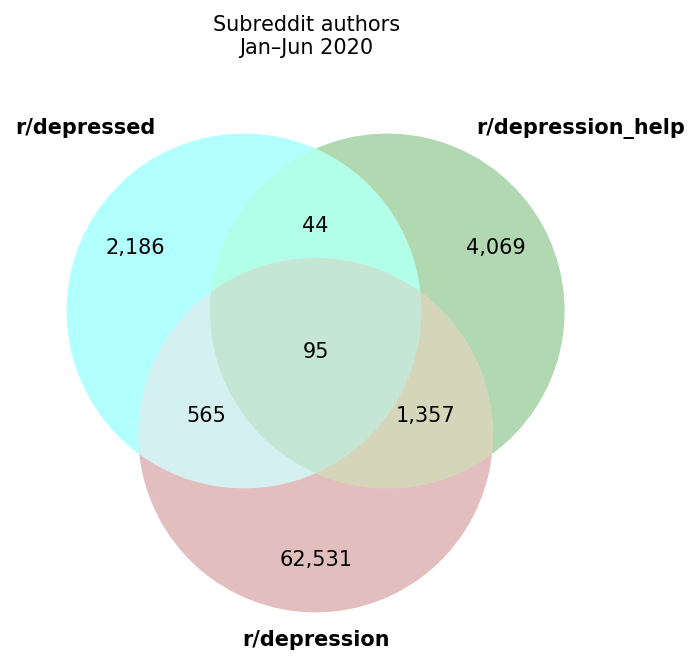

In [12]:
# Creating a venn diagramm to see the overlap between the three subreddits in terms of authors.
fig_authors_venn = plt.figure(figsize=(5, 5), dpi=150)
# This is an unweighter venn diagramm, meaning that all circles are the same size.
authors_venn = venn3_unweighted([set(depression_subreddits_authors2020['r/depressed']),
                  set(depression_subreddits_authors2020['r/depression_help']),
                  set(depression_subreddits_authors2020['r/depression'])],
                 set_labels = (depression_subreddits_authors2020.keys()),
                 set_colors=('cyan', 'green', 'brown'), alpha=.3)

# Formatting the labels.
for text in authors_venn.set_labels:
    text.set_fontsize(10)
    text.set_fontweight('bold')
for text in authors_venn.subset_labels:
    text.set_text('{:,.0f}'.format(int(text.get_text())))
    text.set_fontsize(10)
    
fig_authors_venn.suptitle('Subreddit authors\nJan–Jun 2020', fontsize=10)
fig_authors_venn.savefig('depression_subreddits_authors_venn.png', format='png', bbox_inches = "tight")
plt.show()

It looks like r/depression_help and r/depression had the biggest overlap of 1,452 authors (1,357 + 95) in the first half of 2020. Interestingly, only 95 authors posted in all three subreddits. This means that the user base of each subreddit is, for the most part, pretty unique (those are all users that have submitted a post, not just subscribers).

Next, we will look at the some of the differences between 2020 and the previous two years.

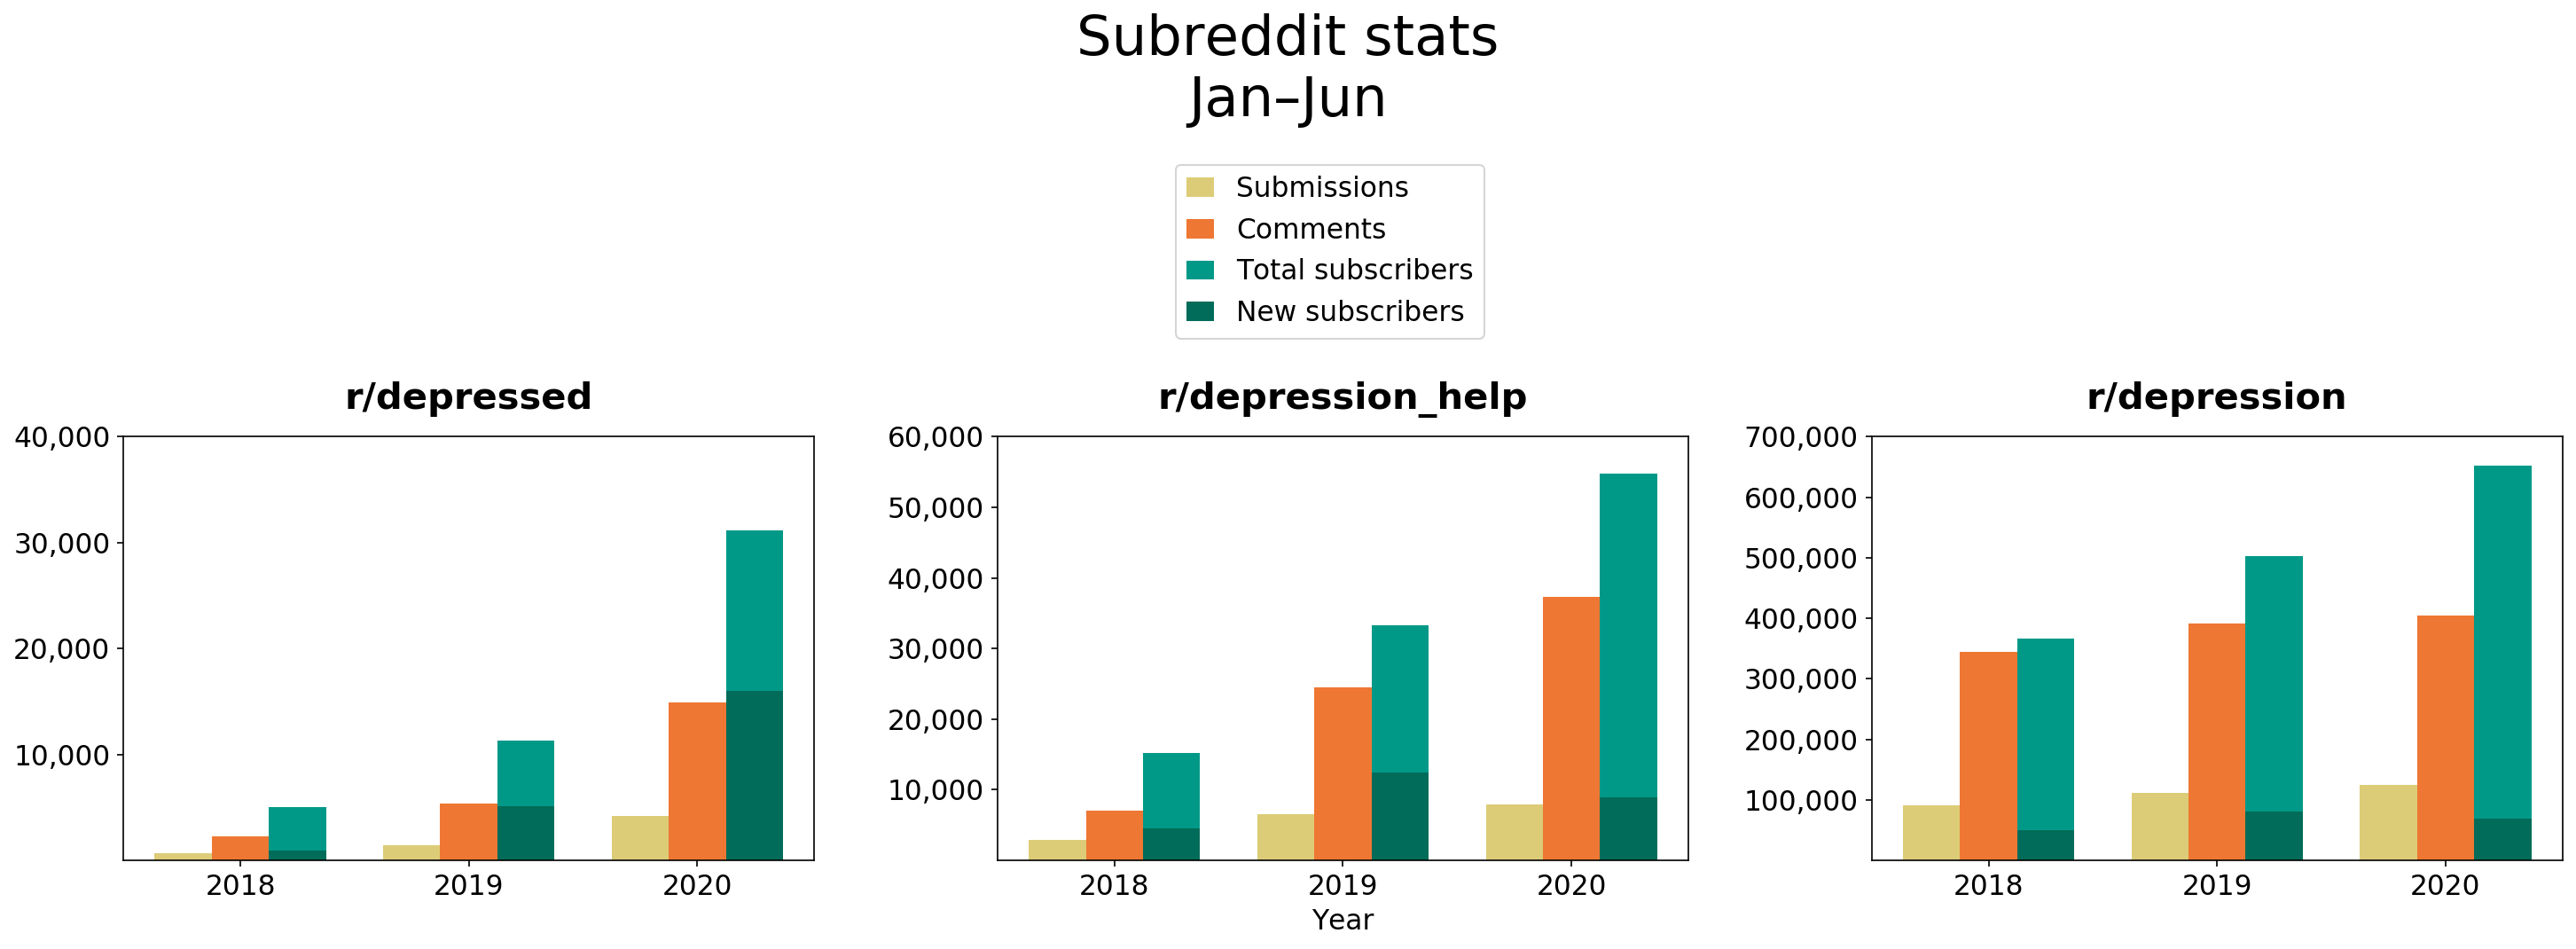

In [13]:
# Let us explore the stats separately for each year and across subreddits. We are going to create a grouped bar plot with submissions, comments and total subscribers and with new subscribers stacked on top of the total subscribers.
fig_stats = plt.figure(figsize=(20, 5), dpi=150)
# Setting the width for each bar and the x coordinates for each stat, so that we could put the bars next to each other without an overlap.
bar_width = 0.25
x1 = range(3)
x2 = [x + bar_width for x in x1]
x3 = [x + bar_width for x in x2]

for i, subreddit in enumerate(depression_subreddits_yearly.keys()):
    ax = fig_stats.add_subplot(1, 3, i+1)
    ax.bar(x1,[depression_subreddits_yearly[subreddit].iloc[0,0],
                            depression_subreddits_yearly[subreddit].iloc[1,0],
                            depression_subreddits_yearly[subreddit].iloc[2,0]], width=bar_width, color='#DDCC77', label='Submissions')
    ax.bar(x2,[depression_subreddits_yearly[subreddit].iloc[0,1],
                            depression_subreddits_yearly[subreddit].iloc[1,1],
                            depression_subreddits_yearly[subreddit].iloc[2,1]], width=bar_width, color='#EE7733', label='Comments')
    ax.bar(x3,[depression_subreddits_yearly[subreddit].iloc[0,2],
                            depression_subreddits_yearly[subreddit].iloc[1,2],
                            depression_subreddits_yearly[subreddit].iloc[2,2]], width=bar_width, color='#009988', label='Total subscribers')
    # Putting the new subscribers on top of the total subscribers (the same x coordinates).
    ax.bar(x3,[depression_subreddits_yearly[subreddit].iloc[0,3],
                            depression_subreddits_yearly[subreddit].iloc[1,3],
                            depression_subreddits_yearly[subreddit].iloc[2,3]], width=bar_width, color='#016c59', label='New subscribers')
    
    # Defining different limits for the y axis according to subreddit and labelling the ticks.
    if i == 0:
        ax.set_ylim(0, 40000)
        ax.yaxis.set_ticks([y for y in range(10000, 50000, 10000)])
    elif i == 1:
        ax.set_ylim(0, 60000)
        ax.yaxis.set_ticks([y for y in range(10000, 70000, 10000)])
        # Labelling the x axis for the bar plot in the middle.
        ax.set_xlabel('Year', fontsize=15)
    else:
        ax.set_ylim(0, 700000)
        ax.yaxis.set_ticks([y for y in range(100000, 800000, 100000)])
    # Formatting the numbers on the y axis to show numbers with a thousands separator.
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    # Modifying and labeling the x ticks, so that they are only three (for each year).
    ax.xaxis.set_ticks([x + bar_width for x in range(3)])
    ax.set_xticklabels(['2018', '2019', '2020'])
    # Increasing the size of the labels.
    ax.tick_params(axis='both', which='major', labelsize=15)
    # Setting the respective subreddit as a title.
    ax.set_title(subreddit, fontweight='bold', fontsize=20, pad=15)
    
# Creating a legend (only one for the whole figure, applies to all three plots).
# Extracting the handles and labels from the last axis in the loop (could be any axis, their legends are equivalent). 
handles, labels = ax.get_legend_handles_labels()
# Using the handles and labels to generate the legend for the figure and positioning it above the plots.
fig_stats.legend(handles, labels, fontsize=15,
                       bbox_to_anchor=(.5, 1.2), loc='upper center', handlelength=1)
# Adding space between the plots.
fig_stats.tight_layout(pad=3)
fig_stats.suptitle(' ', fontsize=30, y=1.235, x=0.5)
fig_stats.savefig('depression_subreddits_stats.png', format='png', bbox_inches = "tight")
fig_stats.suptitle('Subreddit stats\nJan–Jun', fontsize=30, y=1.47, x=0.5)
plt.show()

The bar charts show the natural growth that is usually expected for every subreddit that has a big enough user base. As time passes, the subreddit becomes more popular: more and more people subscribe, submit posts and comment on other people's posts. This is all reflected in the differences between the years. What we are interested in, however, is whether any of those differences are more pronounced for 2020. We can tell that for the most part, the progression from 2018 to 2019 and then to 2020 is smooth, with some notable exceptions:
- For r/depression, change in time is most pronounced in subscribers; submissions and comments do not increase as fast
- For r/depression_help and r/depression, more people subscribed in 2019 than in 2020 (during the first half of the year, that is)
- For r/depressed, submissions, comments, and subscribers have more than doubled from 2019 to 2020.

<i>To aid the visualisation, the bars for each subreddit are roughly the same height, but please note the differences in scaling. We already know that r/depression is the biggest subreddit, followed by r/depression_help and finally by r/depressed. The charts are ordered from small to big.</i>

Next, let us explore the differences in a month-by-month basis, separately for each metric.

In [14]:
# We are going to look at the subscribers for each year over the six month period, but let us first calculate the growth rate from Jan to Jun in percentages and include that in the subsequent plots.
monthly_subscriber_growth = {}
for subreddit, subreddit_df_monthly in depression_subreddits_monthly.items():
    percent_changes = [round(subreddit_df_monthly['Subscribers'].iloc[:6].pct_change(periods=5).iloc[-1], 2),
                       round(subreddit_df_monthly['Subscribers'].iloc[6:12].pct_change(periods=5).iloc[-1], 2),
                       round(subreddit_df_monthly['Subscribers'].iloc[12:].pct_change(periods=5).iloc[-1], 2)]
    
    # Each key in the dictionary is a separate subreddit, and the list assigned to the key contains the growth rate for all three years.
    monthly_subscriber_growth[subreddit] = percent_changes

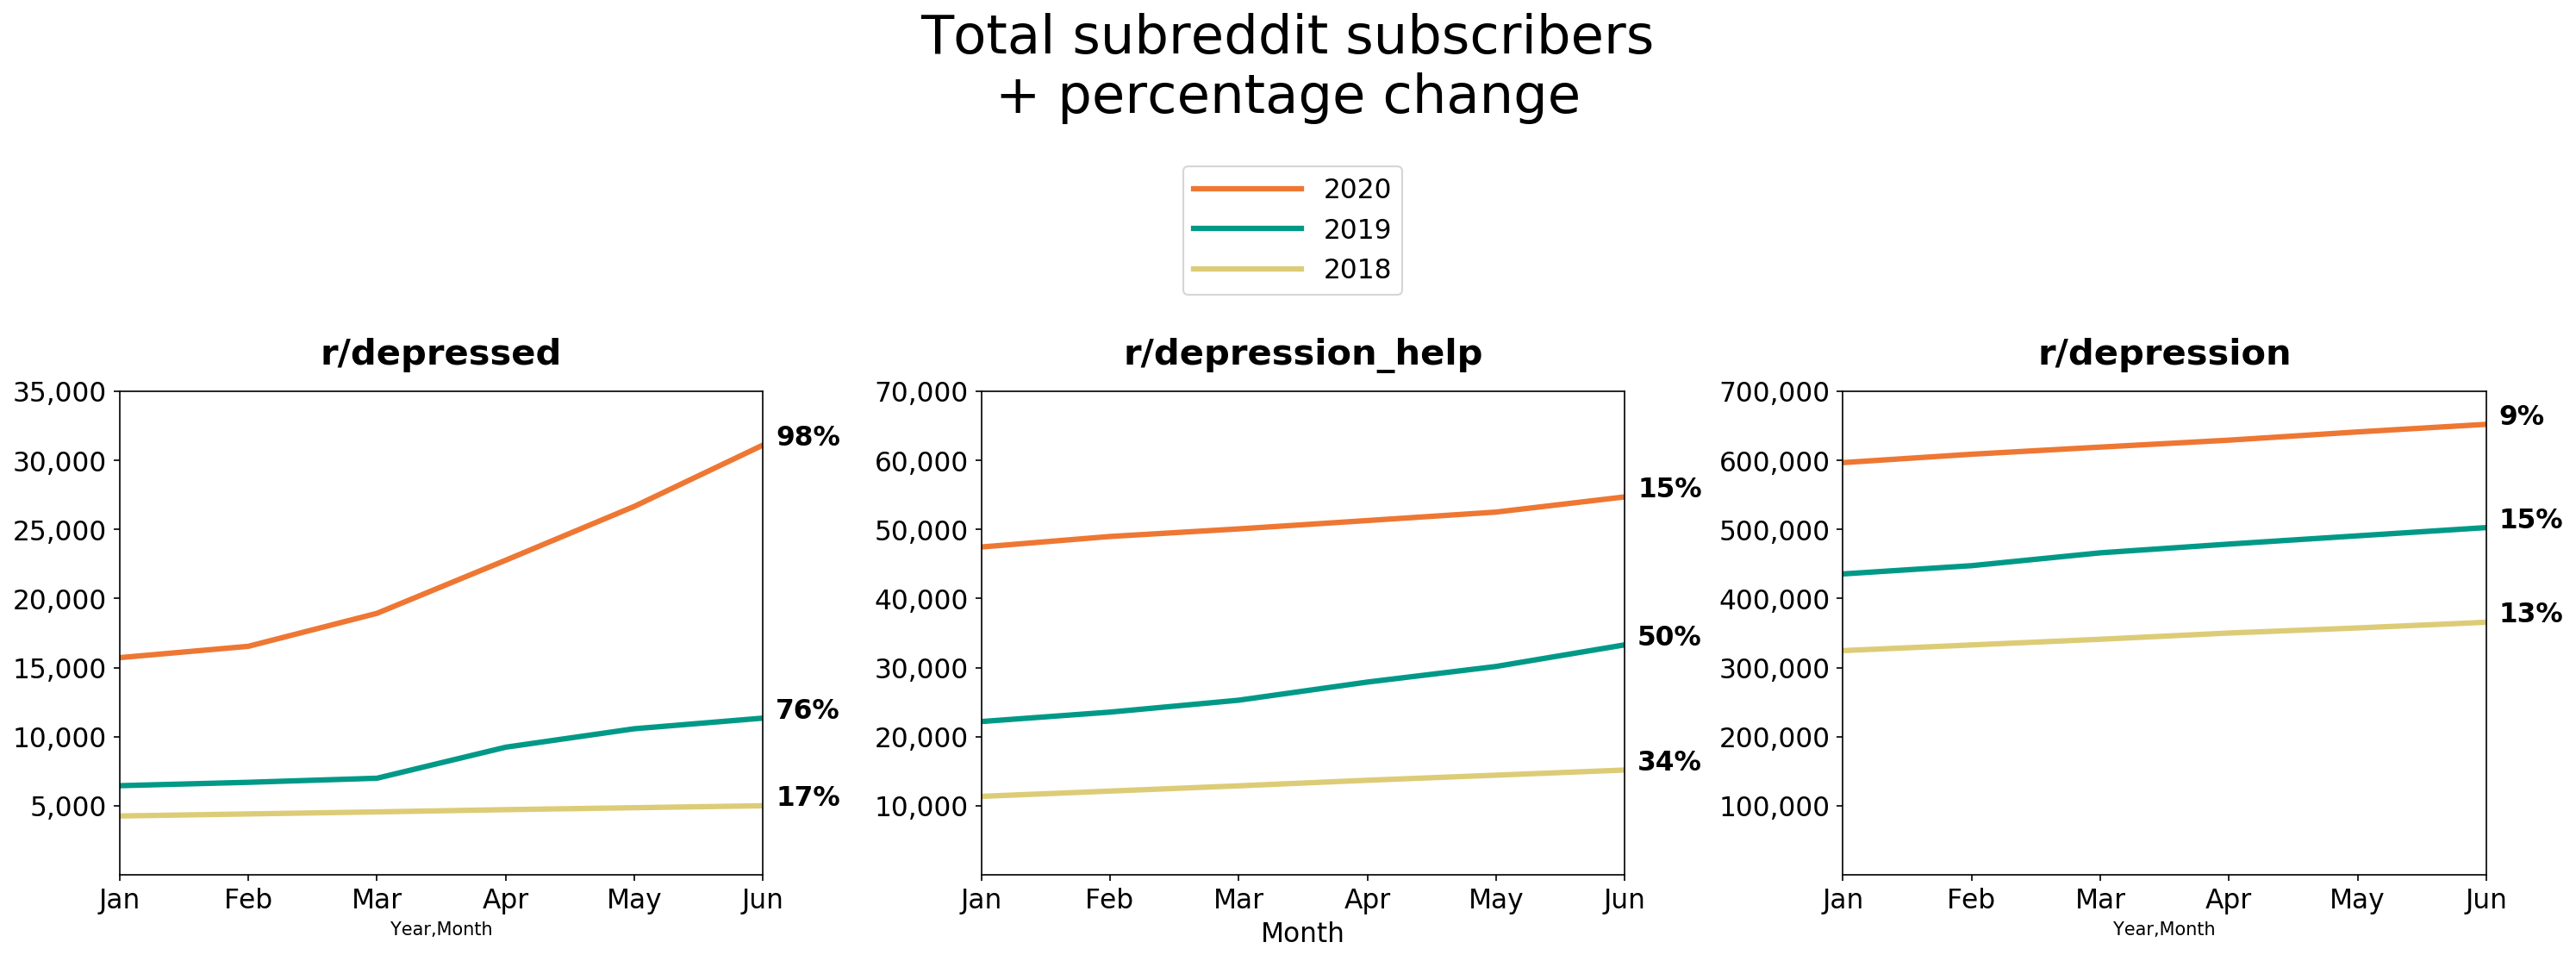

In [15]:
# Creating line charts with the number of total subscribers across months and years.
fig_subscribers = plt.figure(figsize=(20, 5), dpi=150)
for i, subreddit in enumerate(depression_subreddits_monthly.keys()):
    ax = fig_subscribers.add_subplot(1, 3, i+1)
    depression_subreddits_monthly[subreddit]['Subscribers'][12:].plot(ax=ax, color='#EE7733', linewidth=3)
    depression_subreddits_monthly[subreddit]['Subscribers'][6:12].plot(ax=ax, color='#009988', linewidth=3)
    depression_subreddits_monthly[subreddit]['Subscribers'][:6].plot(ax=ax, color='#DDCC77', linewidth=3)
    
    if i == 0:
        ax.set_ylim(0, 35000)
        ax.yaxis.set_ticks([y for y in range(5000, 40000, 5000)])
    elif i == 1:
        ax.set_xlabel('Month', fontsize=15)
        ax.set_ylim(0, 70000)
        ax.yaxis.set_ticks([y for y in range(10000, 80000, 10000)])
    else:
        ax.set_ylim(0, 700000)
        ax.yaxis.set_ticks([y for y in range(100000, 800000, 100000)])
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_title(subreddit, fontweight='bold', fontsize=20, pad=15)
    # Adding the growth rate to the right of the each plot, separately for each year.
    ax.text(5.10, depression_subreddits_monthly[subreddit]['Subscribers'].iloc[-1],
            fontsize=15, fontweight='bold',
            s='{:.0f}%'.format(monthly_subscriber_growth[subreddit][2]*100))
    ax.text(5.10, depression_subreddits_monthly[subreddit]['Subscribers'].iloc[11],
            fontsize=15, fontweight='bold',
            s='{:.0f}%'.format(monthly_subscriber_growth[subreddit][1]*100))
    ax.text(5.10, depression_subreddits_monthly[subreddit]['Subscribers'].iloc[5],
            fontsize=15, fontweight='bold',
            s='{:.0f}%'.format(monthly_subscriber_growth[subreddit][0]*100))

handles, labels = ax.get_legend_handles_labels()
labels = [2020, 2019, 2018]
fig_subscribers.legend(handles, labels, fontsize=15,
                       bbox_to_anchor=(.5, 1.25), loc='upper center', handlelength=4)
fig_subscribers.tight_layout(pad=1)
fig_subscribers.savefig('depression_subreddits_subsribers.png', format='png', bbox_inches = "tight")
fig_subscribers.suptitle('Total subreddit subscribers\n+ percentage change', fontsize=30, y=1.475, x=0.5)
plt.show()

For r/depressed, there was a 98% increase in subscribers from January to June 2020 (subscribers almost doubled). In 2019, there was a similar increase, albeit not as impactful (76%). And in 2018, the increase was pretty modest (17%). This supports our hypothesis: in 2020, r/depressed was gaining new subscribers a lot faster compared to other years.

For r/depression_help and r/depression, however, this was not the case. In 2020, the increase in subscribers from January to June was modest (15% and 9% respectively), lower than the increase for both 2018 and 2019. Essentially, the first half of 2020 was the slowest for those subreddits, while 2019 was the fastest. This is not in line with our hypothesis.

It will be interesting to see the number of new subscribers that the subreddits were gaining each month. This is what the next line chart is all about.

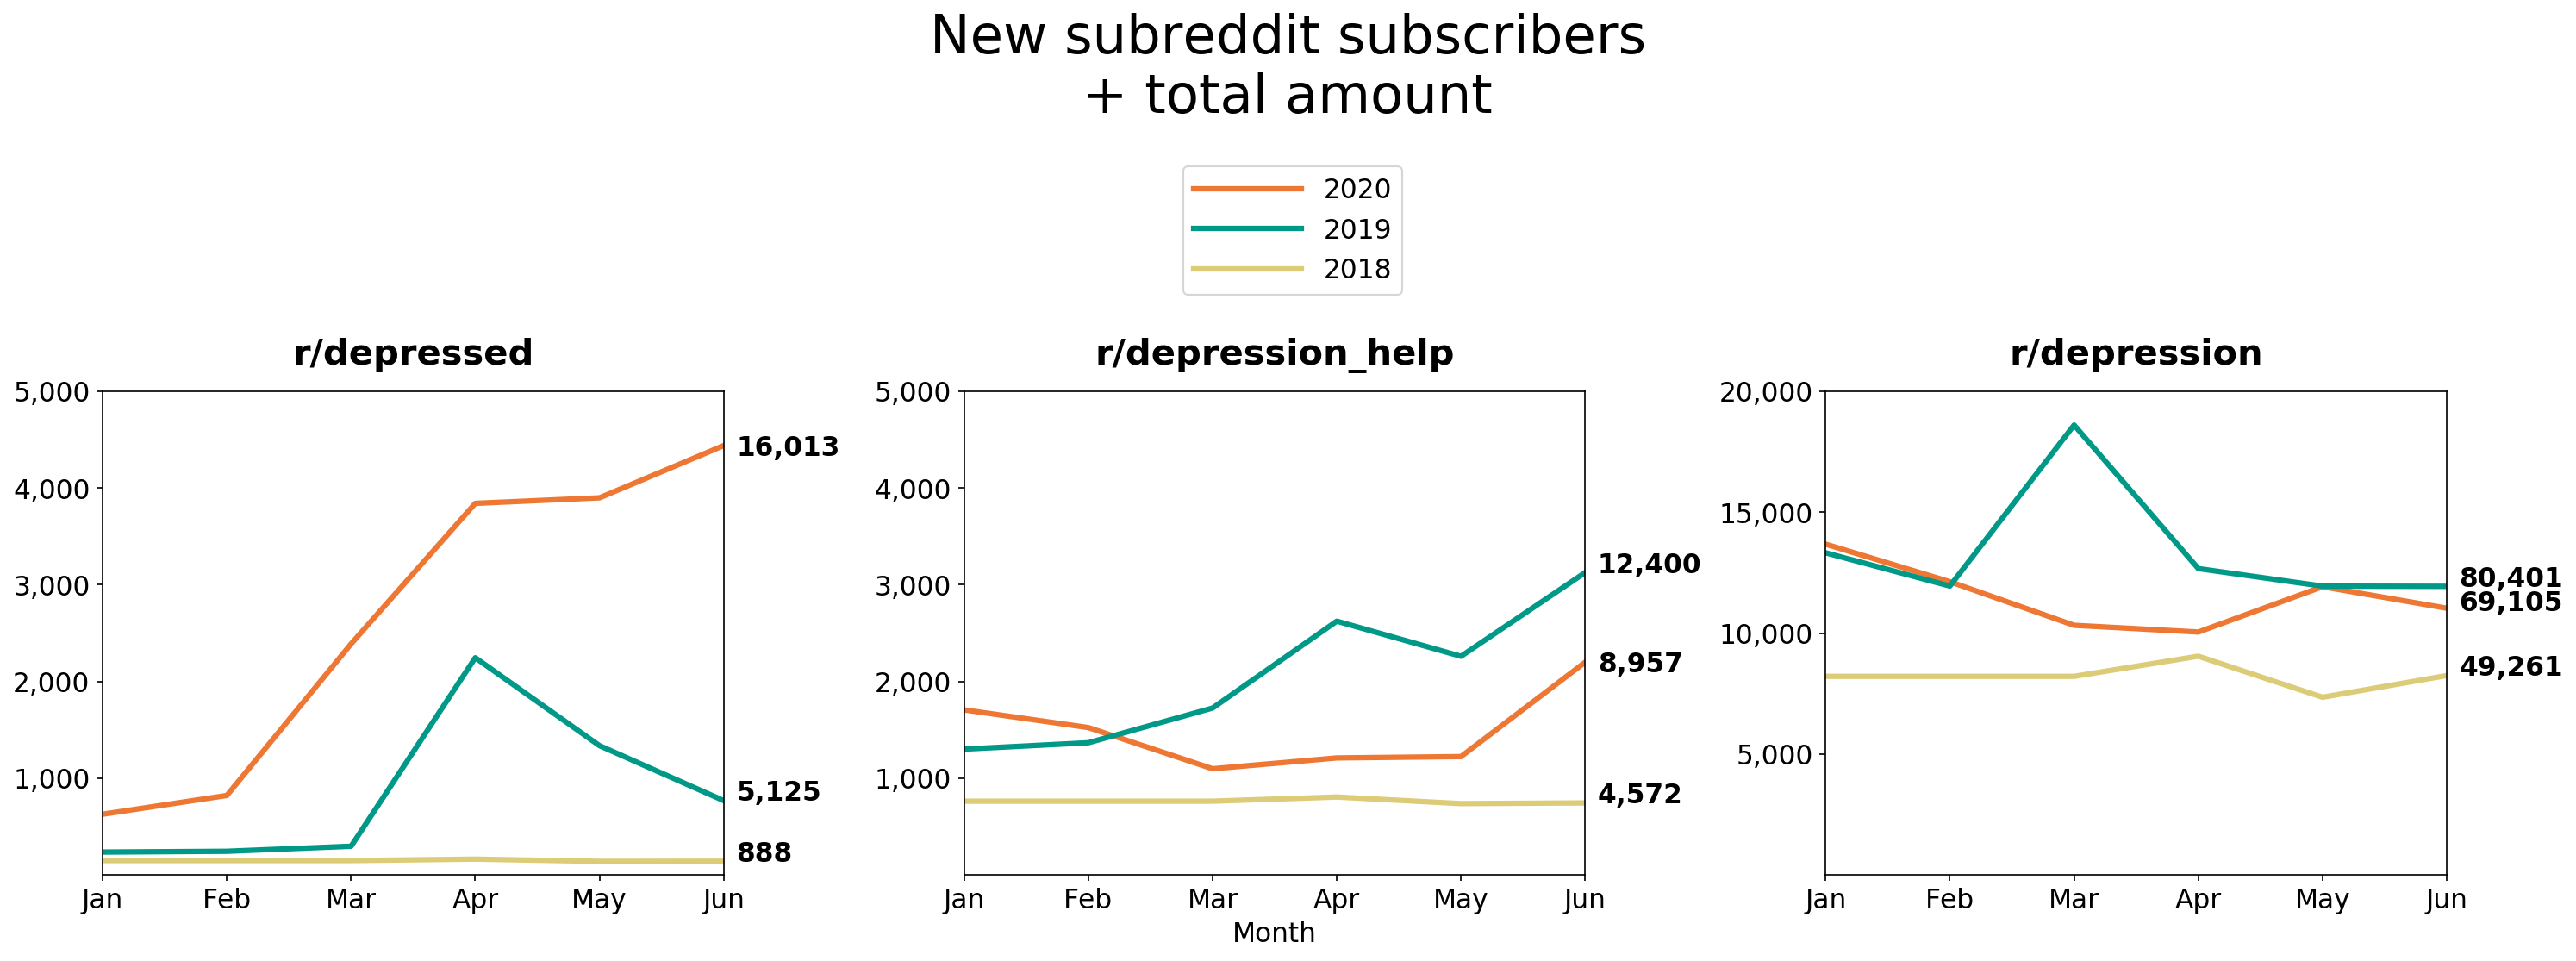

In [16]:
# Plotting the new subscribers.
fig_new_subscribers = plt.figure(figsize=(20, 5), dpi=150)
for i, subreddit in enumerate(depression_subreddits_monthly.keys()):
    ax = fig_new_subscribers.add_subplot(1, 3, i+1)
    depression_subreddits_monthly[subreddit]['New subscribers'][12:].plot(ax=ax, color='#EE7733', linewidth=3)
    depression_subreddits_monthly[subreddit]['New subscribers'][6:12].plot(ax=ax, color='#009988', linewidth=3)
    depression_subreddits_monthly[subreddit]['New subscribers'][:6].plot(ax=ax, color='#DDCC77', linewidth=3)
    ax.set_xlabel('')
    
    if i == 0:
        ax.set_ylim(0, 5000)
        ax.yaxis.set_ticks([y for y in range(1000, 6000, 1000)])
    elif i == 1:
        ax.set_xlabel('Month', fontsize=15)
        ax.set_ylim(0, 5000)
        ax.yaxis.set_ticks([y for y in range(1000, 6000, 1000)])
    else:
        ax.set_xlabel('')
        ax.set_ylim(0, 20000)
        ax.yaxis.set_ticks([y for y in range(5000, 25000, 5000)])
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) 
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_title(subreddit, fontweight='bold', fontsize=20, pad=15)
    # Adding the total amount from Jan to Jun for each year and displaying it to the right of the each plot.
    ax.text(5.10, depression_subreddits_monthly[subreddit]['New subscribers'].iloc[-1]-100,
            fontsize=15, fontweight='bold',
            s='{:,.0f}'.format(depression_subreddits_monthly[subreddit]['New subscribers'][12:].sum()))
    ax.text(5.10, depression_subreddits_monthly[subreddit]['New subscribers'].iloc[11],
            fontsize=15, fontweight='bold',
            s='{:,.0f}'.format(depression_subreddits_monthly[subreddit]['New subscribers'][6:12].sum()))
    ax.text(5.10, depression_subreddits_monthly[subreddit]['New subscribers'].iloc[5],
            fontsize=15, fontweight='bold',
            s='{:,.0f}'.format(depression_subreddits_monthly[subreddit]['New subscribers'][:6].sum()))

handles, labels = ax.get_legend_handles_labels()
labels = [2020, 2019, 2018]
fig_new_subscribers.legend(handles, labels, fontsize=15,
                       bbox_to_anchor=(.5, 1.25), loc='upper center', handlelength=4)
fig_new_subscribers.tight_layout(pad=1)
fig_new_subscribers.savefig('depression_subreddits_new_subsribers.png', format='png', bbox_inches = "tight")
fig_new_subscribers.suptitle('New subreddit subscribers\n+ total amount', fontsize=30, y=1.475, x=0.5)
plt.show()

r/depressed had its highest number of new subscribers in 2020 (16,013), and there was also a rapid gain from February to April 2020, extending well into June. This is a significant increase compared to other years, and it most certainly indicates bigger engagement with the subreddit at the time. For 2019, the numbers peak in April and then drop.

For r/depression_help, the biggest increase was in 2019 (12,400 new subscribers compared to only 8,957 in 2020). This was similarly observed for r/depression (80,401 in 2019 compared to 69,105 in 2020). What is more, there was s noticeable drop in new subscribers between March and May 2020 (for r/depression_help) and between March and April 2020 (for r/depression), which does not correspond to the increase observed for r/depressed.

For all three subreddits, 2018 saw the fewest new subscribers.

Interestingly, the peak pattern of r/depression_help in 2019 is very similar to that of r/depressed in 2020, but I cannot offer an explanation for that.

Next, it might be helpful to see how the number of submissions and/or comments changed over time. However, there is a chance that we do not need to use both metrics as one of them is probably more informative than the other.

In [17]:
# Let's see what the correlation is between submissions and comments.
print('Correlation between Submissions and Comments\n')
for subreddit, subreddit_df_monthly in depression_subreddits_monthly.items():
    print('{}: {}'.format(subreddit, round(subreddit_df_monthly['Submissions'].corr(subreddit_df_monthly['Comments']), 2)))

Correlation between Submissions and Comments

r/depressed: 1.0
r/depression_help: 0.97
r/depression: 0.8


Looking at the bar chart, it is easy to notice that the growth of submissions corresponds to the growth of commenters. The above correlations confirm this: submissions are very highly correlated with comments. This means that each metric provides enough information on its own, so only one of them is really needed.

<i>It also looks as if the correlation drops the more subscribers there are in a subreddit. However, we have only three data points (three subreddits) and there is no way to confirm that at the moment.</i>

I would rather use the submissions instead of the subscribers for several reasons:
- Comments can be added up to six months after a post is submitted. Meanwhile, pushshift updates the comment count on each post only once, approximately 24 hours after its submission. This means that our data is very likely incomplete
- As I mentioned previously, subscribers are more likely to comment than other people because the posts show up in their newsfeed. However, we are interested in the engagement of all Reddit users, not just subscribers, so looking at submissions might be more informative in this case
- Submission as an indicator of users' mental state are arguably better than comments. Users choose to comment for various reasons (e.g. the post appeared in their newsfeed, the author of the post asked them follow-up questions, the original post was very provocative and prompted a response). Therefore, the number of comments alone should not be used to gauge the engagement with a given subreddit.

We already know that each year, there are more submissions than the year before because the subreddit is getting bigger with time. Therefore, the number of submissions alone will not tell us much. Instead, we will be using the submissions/subscribers ratio for a given month. That way, we can measure the engagement with the subreddit after adjusting for its natural growth.

In [18]:
# Diving submissions by the total subscribers for each month, so that we can get the monthly submissions/subscribers ratio.
for subreddit, subreddit_df_monthly in depression_subreddits_monthly.items():
    subreddit_df_monthly['Submissions per subscriber'] = subreddit_df_monthly['Submissions'] / subreddit_df_monthly['Subscribers']
    
    depression_subreddits_monthly[subreddit] = subreddit_df_monthly

# Diving submissions by the total subscribers for each year, so that we can get the yearly submissions/subscribers ratio.
for subreddit, subreddit_df_yearly in depression_subreddits_yearly.items():
    subreddit_df_yearly['Submissions per subscriber'] = subreddit_df_yearly['Submissions'] / subreddit_df_yearly['Subscribers']
    
    depression_subreddits_yearly[subreddit] = subreddit_df_yearly

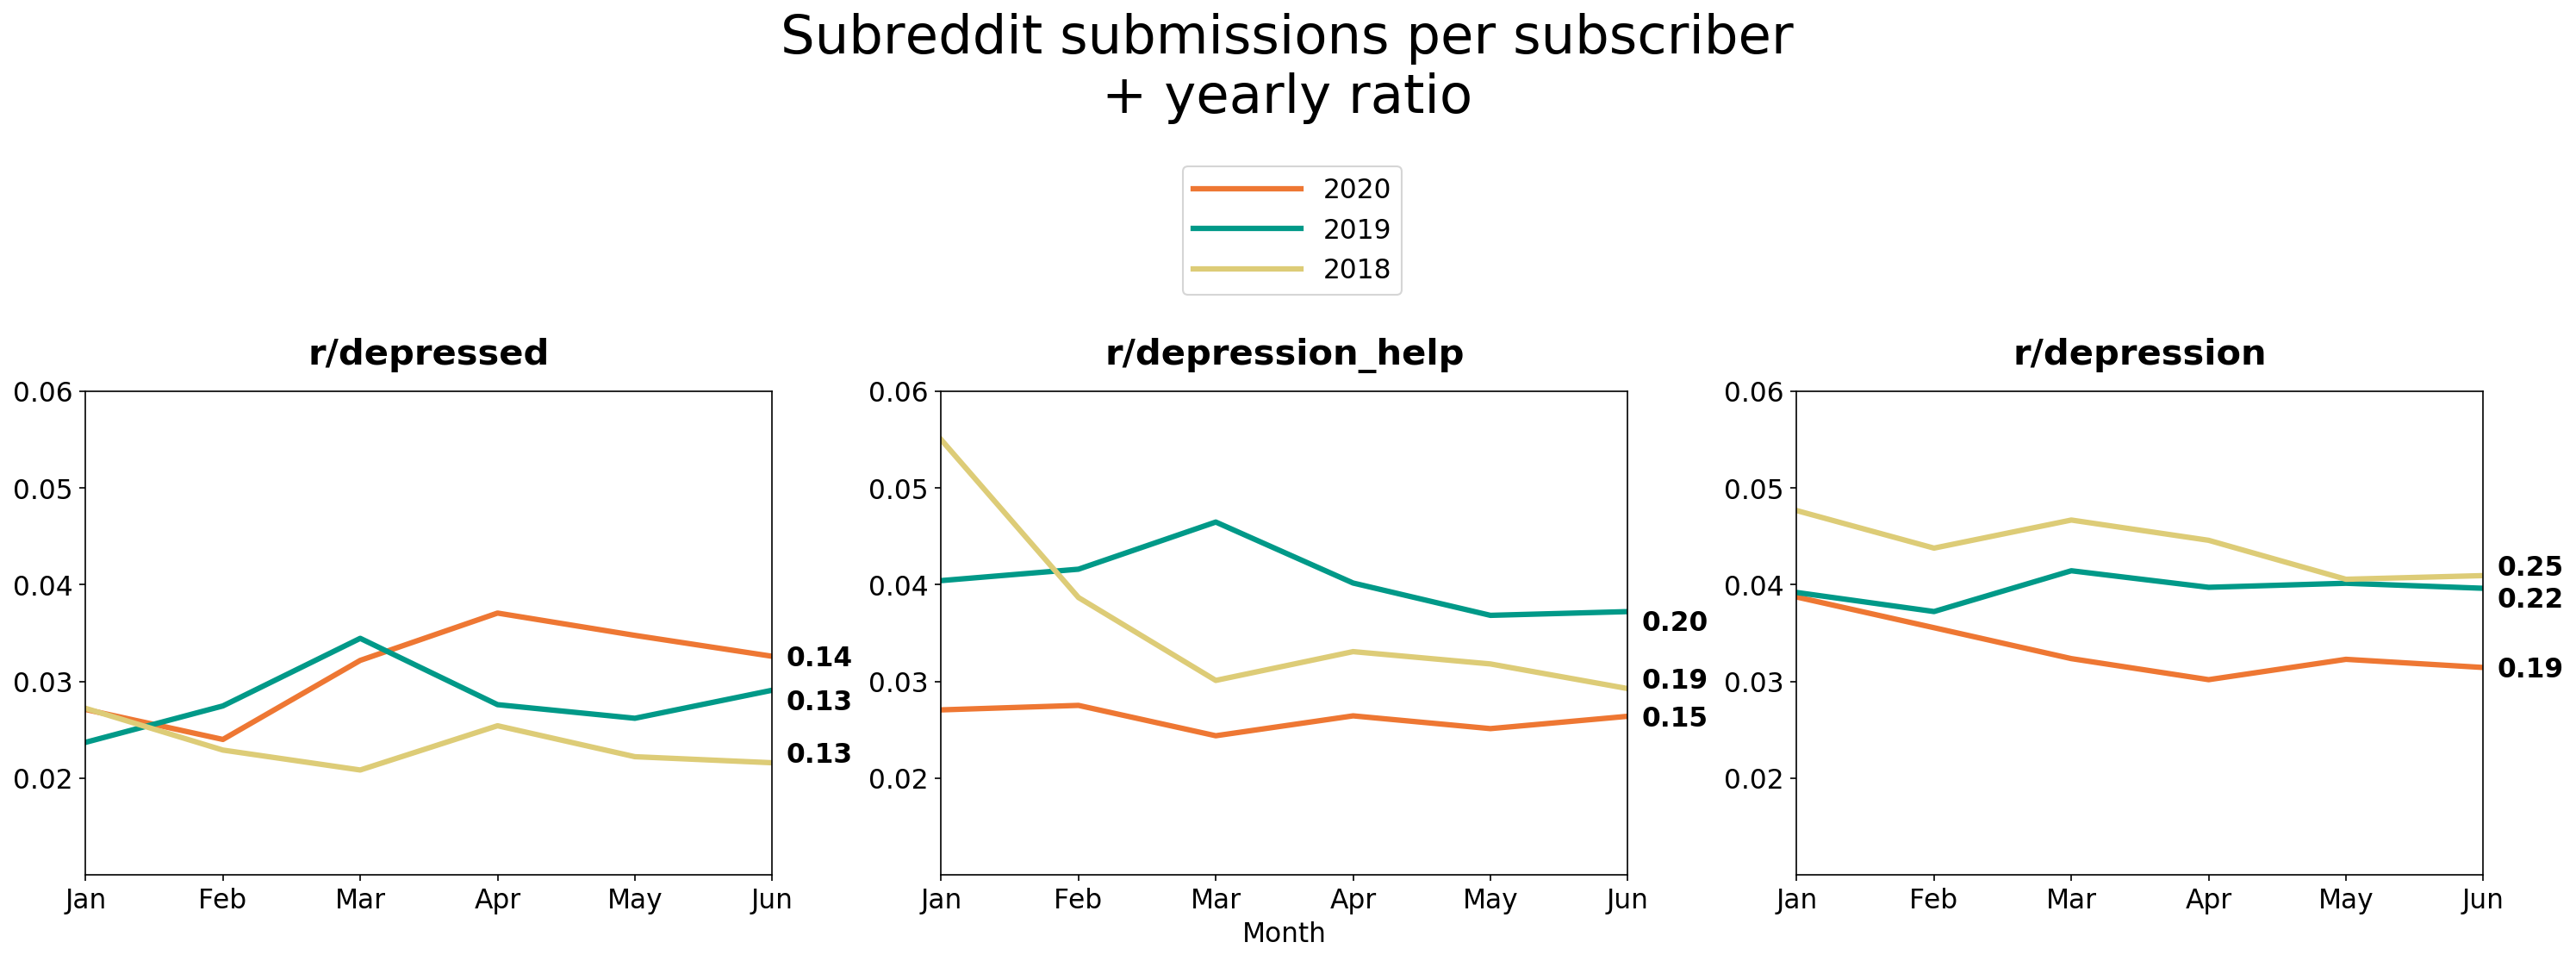

In [19]:
# Plotting the submissions per subscriber.
fig_submissions = plt.figure(figsize=(20, 5), dpi=150)
for i, subreddit in enumerate(depression_subreddits_monthly.keys()):
    ax = fig_submissions.add_subplot(1, 3, i+1)
    depression_subreddits_monthly[subreddit]['Submissions per subscriber'][12:].plot(ax=ax, color='#EE7733', linewidth=3)
    depression_subreddits_monthly[subreddit]['Submissions per subscriber'][6:12].plot(ax=ax, color='#009988', linewidth=3)
    depression_subreddits_monthly[subreddit]['Submissions per subscriber'][:6].plot(ax=ax, color='#DDCC77', linewidth=3)
    ax.set_xlabel('')
    
    if i == 1:
        ax.set_xlabel('Month', fontsize=15)
    ax.set_ylim(0.01, 0.06)
    ax.yaxis.set_ticks([y for y in np.arange(0.02, 0.07, 0.01)])
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_title(subreddit, fontweight='bold', fontsize=20, pad=15)
    # Adding the yearly ratio and displaying it to the right of the each plot.
    ax.text(5.10, depression_subreddits_monthly[subreddit]['Submissions per subscriber'].iloc[-1]-0.001,
            fontsize=15, fontweight='bold',
            s='{:.2f}'.format(depression_subreddits_yearly[subreddit]['Submissions per subscriber'].iloc[2]))
    ax.text(5.10, depression_subreddits_monthly[subreddit]['Submissions per subscriber'].iloc[11]-0.002,
            fontsize=15, fontweight='bold',
            s='{:.2f}'.format(depression_subreddits_yearly[subreddit]['Submissions per subscriber'].iloc[1]))
    ax.text(5.10, depression_subreddits_monthly[subreddit]['Submissions per subscriber'].iloc[5],
            fontsize=15, fontweight='bold',
            s='{:.2f}'.format(depression_subreddits_yearly[subreddit]['Submissions per subscriber'].iloc[0]))

handles, labels = ax.get_legend_handles_labels()
labels = [2020, 2019, 2018]
fig_submissions.legend(handles, labels, fontsize=15,
                       bbox_to_anchor=(.5, 1.25), loc='upper center', handlelength=4)
fig_submissions.tight_layout(pad=1)
fig_submissions.savefig('depression_subreddits_submissions.png', format='png', bbox_inches = "tight")
fig_submissions.suptitle('Subreddit submissions per subscriber\n+ yearly ratio', fontsize=30, y=1.475, x=0.5)
plt.show()

For r/depressed, the highest ratio was in 2020 (0,14 submissions per subscriber). There was also a noticeable increase between February and April of the same year. Still, it was not as pronounced compared to previous years. This suggests that the influx of new subscribers in 2020 was not actually associated with a lot of submissions – no more than one than one would usually expect. From 2019 to 2020, there was only a small change of 0.01.

For r/depression_help and r/depression, we can tell that 2020 had the fewest submissions per subscriber. Both 2018 and 2019 were clearly ahead in that regard, suggesting that those subreddits have lately seen less engagement than usual. This is mostly in line with our previous observations.

## Conclusion: are Reddit users in 2020 more depressed than usual?

We investigated three subreddits (r/depressed, r/depression_help and r/depression, ordered from small to big), which were similar in scope and had mostly unique user base. We compared the numbers of submissions, total subscribers and new subscribers between January and June for three years in a row (2018, 2019 and 2020) and looked for any changes in the engagement that each subreddit received.

The short answer to the question above, based on the data that we have, is <b>No</b>. For r/depression and r/depression_help, there was nothing to suggest that its user base was more active in 2020. On the contrary: most metrics suggested a bigger engagement in 2019 and even in 2018 in some cases.

For r/depressed (the smallest subreddit of the three), there is indeed reason to believe that it was more active than usual due to a significant increase in subscribers earlier his year. At the same time, however, the number of submissions per subscriber was only a little higher than in previous years.

The results of the project are to be interpreted with certain <b>limitations</b> in mind:
- The level of engagement with a subreddit is not necessarily associated with actual depression, we only believe it might be. Similarly, when an individual starts posting and commenting more on depression-oriented subreddits, it does not automatically mean that they are depressed
- We did not analyse the contents of the posts to make sure that all of them were related to the topic of the subreddits. For example, what if there was a spam attack, leading to artificial increase in posts? We did not account for that possibility
- The subreddits were of different sizes, and even though we conducted our analysis with that in mind, there is still some reason for concern. For example, it could be that any given subreddit receives more engagement around a certain subscriber milestone (e.g. 10,000 or 100,000 subscribers). Or what if a subreddit was heavily advertised on other subreddits or even outside of Reddit, leading to a rapid increase of subscribers? We did not explore those possibilities
- The subscriber data for January and March 2018 was missing, so we did a mean imputation. However, this likely did not reflect the real state of the data at that time.

<b>All things considered, there is not much evidence to suggest that Reddit users have been more depressed in 2020.</b>